<a href="https://colab.research.google.com/github/JohnTichenor/Locating-Bacterial-Flagellar-Motors/blob/main/Lab9_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 Report:
## Final Project Codebase

## Project Title: Detecting Bacterial Flagellar Motors Using Faster R-CNN

### Group Members: John Tichenor Maddox Spinelli

--------------------

## Install Packages

In [16]:
!pip install torch torchvision
!pip install tqdm

## Import Dependencies

In [17]:
# ==== PyTorch Core ====
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset

# ==== TorchVision for Computer Vision ====
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn  # Prebuilt Faster R-CNN model
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor  # Custom predictor head
import torchvision.transforms.v2 as T  # v2 transforms for detection tasks (handle boxes/labels)
from torchvision.datasets import ImageFolder  # For quick folder-based datasets

# ==== Data Handling and Utilities ====
from PIL import Image  # Image loading/manipulation
import json  # JSON file reading/writing
import os  # Operating system utilities
import numpy as np  # Numerical computations
import pandas as pd  # DataFrame support

# ==== Progress Bars and Parallel Processing ====
from tqdm.notebook import tqdm  # Jupyter-friendly progress bar
import threading  # Threading for concurrent tasks
from contextlib import nullcontext  # Context manager utility
from concurrent.futures import ThreadPoolExecutor  # For thread pools
import time  # Timing utilities

# ==== Visualization ====
import matplotlib.pyplot as plt  # Plotting

# ==== Metrics ====
from sklearn.metrics import fbeta_score  # F-beta metric for evaluation

import cv2  # OpenCV for advanced image and video operations


## Mount Drive

In [18]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Data

In [19]:
TRAIN_DIR = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/train"
TEST_DIR = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/test"
LABELS_PATH = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/train_labels.csv"
SUBMIT_PATH = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/submission.csv"
BOUNDING_BOXES_PATH = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/bounding_boxes_32.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Import labels
labels_df = pd.read_csv(LABELS_PATH)

## Format Dataset

In [20]:

class TomogramDataset(Dataset):
    def __init__(self, root_dir, json_path, transforms=None):
        """
        root_dir: path to the folder containing tomogram subfolders
        json_path: bounding box annotations (from motor_bounding_boxes.json)
        """
        self.root_dir = root_dir
        self.transforms = transforms

        with open(json_path) as f:
            self.annotations = json.load(f)

        self.image_paths = list(self.annotations.keys())  # e.g., tomo_00e047/slice_0169.jpg

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        image = Image.open(img_path).convert("RGB")

        boxes = torch.tensor([ann["bbox"] for ann in self.annotations[rel_path]], dtype=torch.float32)
        labels = torch.tensor([ann["label"] for ann in self.annotations[rel_path]], dtype=torch.int64)

        # Fix for empty boxes: always shape (N, 4), even if N==0
        if boxes.numel() == 0:
            boxes = boxes.reshape(0, 4)
        if labels.numel() == 0:
            labels = labels.reshape(0,)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms:
          image, target = self.transforms(image, target)

        return image, target

## Transform and Split Data

In [21]:
batch_size = 4

# Define the transformation pipeline for training data
train_transforms = T.Compose([
    T.ToImage(),                                # Convert PIL image to torch.Tensor and add metadata
    T.ToDtype(torch.float32, scale=True),       # Ensure tensor is float32 and scaled to [0,1]
    #T.RandomHorizontalFlip(p=0.5),              # Randomly flip images and boxes horizontally (augmentation)
    #T.RandomRotation(degrees=10),               # Randomly rotate images and boxes (augmentation)
    #T.ColorJitter(brightness=0.2, contrast=0.2),# Randomly change brightness and contrast (augmentation)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),   # Normalize using computed dataset mean and std
])

# Define the transformation pipeline for validation data (no augmentation!)
val_transforms = T.Compose([
    T.ToImage(),                                # Convert PIL image to torch.Tensor
    T.ToDtype(torch.float32, scale=True),       # Convert to float32 and scale
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),   # Use same normalization as training
])

# Instantiate the full dataset WITHOUT transforms,
# just to get a stable, reproducible split of train/val indices
full_dataset = TomogramDataset(
    root_dir=TRAIN_DIR,
    json_path=BOUNDING_BOXES_PATH,
    transforms=None  # No transforms needed for just splitting!
)

# Calculate split sizes for 80/20 train/validation split
num_total = len(full_dataset)
num_train = int(0.8 * num_total)
num_val = num_total - num_train

# Randomly permute indices for reproducible splitting
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(num_total, generator=generator).tolist()

# Assign indices to training and validation sets
train_indices = indices[:num_train]
val_indices = indices[num_train:]

# Create two dataset objects, each with their respective transforms
train_full = TomogramDataset(
    root_dir=TRAIN_DIR,
    json_path=BOUNDING_BOXES_PATH,
    transforms=train_transforms,   # With augmentations
)

val_full = TomogramDataset(
    root_dir=TRAIN_DIR,
    json_path=BOUNDING_BOXES_PATH,
    transforms=val_transforms,     # No augmentations
)

# Create Subsets using the split indices (so each only sees its own portion of data)
train_dataset = Subset(train_full, train_indices)
val_dataset = Subset(val_full, val_indices)

# Create DataLoaders for training and validation
# The collate_fn lambda is needed for batching object detection targets
train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: tuple(zip(*x))
)

validation_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)



## Define Model

In [22]:
# Load a pre-trained Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classification head
NUM_CLASSES = 2  # 1 motor class + 1 background
IN_FEATURES = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(IN_FEATURES, NUM_CLASSES)

# Put model on GPU
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Define Hyperparameters

In [23]:
num_epochs = 15
lr = 0.005
score_threshold = 0.3
scheduler_step = 5,
scheduler_gamma = 0.5,

# Train Model

In [24]:
#===== Helper Function to Compute Evaluation Metrics =====

def compute_euclidean_distance(boxA, boxB):
  """
  Compute the Euclidean distance between the centers of two bounding boxes.

  Args:
      boxA (array-like): [x1, y1, x2, y2]
      boxB (array-like): [x1, y1, x2, y2]

  Returns:
      float: Euclidean distance between the centers
  """
  coordA = np.array([(boxA[0] + boxA[2]) / 2, (boxA[1] + boxA[3]) / 2])
  coordB = np.array([(boxB[0] + boxB[2]) / 2, (boxB[1] + boxB[3]) / 2])

  return np.linalg.norm(coordA - coordB)


def compute_f2_score(pred_boxes, gt_boxes, voxel_spacing, euclidean_threshold=1000):
    """
    Compute F2 score for a single image, given predicted and ground-truth boxes.

    Args:
        pred_boxes (np.ndarray): Array of predicted boxes [N_pred, 4]
        gt_boxes (np.ndarray): Array of ground truth boxes [N_gt, 4]
        euclidean_threshold (float): Distance threshold to consider a detection a true positive.

    Returns:
        float: F2 score for this image
    """
    matched_gt = set()
    tp = 0  # True positives

    # Match predicted boxes to ground-truth boxes
    for pred_box in pred_boxes:
        for i, gt_box in enumerate(gt_boxes):
            if i in matched_gt:
                continue  # Skip already matched gt boxes
            if compute_euclidean_distance(pred_box, gt_box) <= (euclidean_threshold/voxel_spacing):
                tp += 1
                matched_gt.add(i)
                break  # Move to next predicted box

    fp = len(pred_boxes) - tp  # False positives
    fn = len(gt_boxes) - tp    # False negatives

    beta2 = 4  # beta^2 for F2 score (beta=2)

    # Calculate precision and recall, avoid division by zero
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    if precision + recall == 0:
        return 0.0

    # F2 score formula
    f2 = (1 + beta2) * (precision * recall) / (beta2 * precision + recall)
    return f2


def train_and_validate_detector(
    model,
    train_data_loader,
    validation_data_loader,
    device,
    compute_f2_score,  # pass your F2 function
    num_epochs=10,
    lr=0.005,
    score_threshold=0.1,
    scheduler_step = 3,
    scheduler_gamma = 0.5,
):
    """
    Train and validate a PyTorch object detector with F2 evaluation.

    Args:
        model: PyTorch detection model (e.g., Faster R-CNN)
        train_data_loader: Dataloader for training set
        validation_data_loader: Dataloader for validation set
        device: 'cuda' or 'cpu'
        compute_f2_score: Function to compute F2 (pred_boxes, gt_boxes)
        num_epochs: Number of training epochs
        lr: Learning rate
        score_threshold: Minimum score to keep predicted boxes
        train_losses (list): List to store training losses
        val_f2s_all (list): List to store validation F2 scores
    """
    # Set up optimizer and scheduler
    optimizer = torch.optim.SGD(
        model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005
    )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    train_losses = []
    val_f2s_all = []

    for epoch in range(num_epochs):
        # --- Training phase ---
        model.train()
        total_loss = 0.0
        pbar = tqdm(train_data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

        for images, targets in pbar:
            # Move images and targets to the selected device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


            # Forward pass, compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        # Average training loss for this epoch
        avg_train_loss = total_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)
        print(f"[Epoch {epoch + 1}/{num_epochs}] Loss: {avg_train_loss:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

        # --- Validation phase ---
        model.eval()
        val_f2s = []
        with torch.no_grad():
            for images, targets in tqdm(validation_data_loader, desc="Validation", leave=False):
                images = [img.to(device) for img in images]
                gt_boxes_batch = [t["boxes"].cpu().numpy() for t in targets]  # Get GT boxes as numpy arrays

                # Get voxel_spacing_list for the current batch
                voxel_spacing_list = []
                for t in targets:
                    dataset_idx = t["image_id"].item()
                    rel_path = full_dataset.image_paths[dataset_idx]
                    tomo_id = rel_path.split("/")[0]
                    spacing = labels_df.loc[labels_df['tomo_id'] == tomo_id, 'Voxel spacing'].values
                    if len(spacing) > 0:
                        voxel_spacing_list.append(spacing[0])
                    else:
                        voxel_spacing_list.append(None)

                outputs = model(images)  # Get model predictions

                for pred, gt_boxes, voxel_spacing in zip(outputs, gt_boxes_batch, voxel_spacing_list):
                    pred_boxes = pred["boxes"].cpu().numpy()
                    # Only keep predictions with score above threshold
                    if "scores" in pred:
                        keep = pred["scores"].cpu().numpy() > score_threshold
                        pred_boxes = pred_boxes[keep]
                    # Compute F2 score for this sample
                    f2 = compute_f2_score(pred_boxes, gt_boxes, voxel_spacing)
                    val_f2s.append(f2)

        # Average F2 score for this validation epoch
        avg_f2 = sum(val_f2s) / len(val_f2s) if val_f2s else 0.0
        val_f2s_all.append(avg_f2)
        print(f"[Epoch {epoch + 1}/{num_epochs}] Validation F2: {avg_f2:.4f}")

    return train_losses, val_f2s_all

# --------- Usage ---------

train_losses, val_f2s_all = train_and_validate_detector(
     model, train_data_loader, validation_data_loader, device, compute_f2_score,
     num_epochs=num_epochs, lr=lr, score_threshold=score_threshold, scheduler_step=scheduler_step,
     scheduler_gamma=scheduler_gamma
     )

Epoch 1/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 1/15] Loss: 0.1110


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 1/15] Validation F2: 0.1694


Epoch 2/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 2/15] Loss: 0.0782


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 2/15] Validation F2: 0.2257


Epoch 3/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 3/15] Loss: 0.0916


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 3/15] Validation F2: 0.2752


Epoch 4/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 4/15] Loss: 0.0905


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 4/15] Validation F2: 0.3464


Epoch 5/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 5/15] Loss: 0.0811


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 5/15] Validation F2: 0.3285


Epoch 6/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 6/15] Loss: 0.0718


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 6/15] Validation F2: 0.4245


Epoch 7/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 7/15] Loss: 0.0567


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 7/15] Validation F2: 0.4340


Epoch 8/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 8/15] Loss: 0.0466


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 8/15] Validation F2: 0.4432


Epoch 9/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 9/15] Loss: 0.0398


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 9/15] Validation F2: 0.4294


Epoch 10/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 10/15] Loss: 0.0323


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 10/15] Validation F2: 0.4155


Epoch 11/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 11/15] Loss: 0.0265


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 11/15] Validation F2: 0.4212


Epoch 12/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 12/15] Loss: 0.0233


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 12/15] Validation F2: 0.4170


Epoch 13/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 13/15] Loss: 0.0207


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 13/15] Validation F2: 0.4144


Epoch 14/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 14/15] Loss: 0.0186


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 14/15] Validation F2: 0.4155


Epoch 15/15:   0%|          | 0/147 [00:00<?, ?it/s]

[Epoch 15/15] Loss: 0.0178


Validation:   0%|          | 0/37 [00:00<?, ?it/s]

[Epoch 15/15] Validation F2: 0.4189


## Export Model and Metrics

In [25]:
def export_model_and_metrics(
    model,
    folder,
    train_losses=None,
    val_metrics=None,
    num_epochs=None,
    lr=None,
    score_threshold=None,
    scheduler_step=None,
    scheduler_gamma=None,
    extra_hparams=None  # for extensibility!
):
    """
    Exports model weights and metrics (including hyperparameters) to a specified folder.
    Model saved as 'model.pth', metrics/hyperparams as 'metrics.json'.

    Args:
        model: PyTorch model instance.
        folder (str): Output directory.
        train_losses (list, optional): Training losses.
        val_metrics (list, optional): Validation metrics (e.g. F2).
        num_epochs (int, optional): Number of epochs.
        lr (float, optional): Learning rate.
        score_threshold (float, optional): Detection score threshold.
        scheduler_step (int, optional): LR scheduler step size.
        scheduler_gamma (float, optional): LR scheduler gamma.
        extra_hparams (dict, optional): Any other hyperparameters.
    """
    os.makedirs(folder, exist_ok=True)

    # Save model
    model_path = os.path.join(folder, "model.pth")
    model_cpu = model.to('cpu')
    torch.save(model_cpu.state_dict(), model_path)

    # Prepare metrics/hyperparameters dict
    metrics = {
        "train_losses": train_losses,
        "val_metrics": val_metrics,
        "num_epochs": num_epochs,
        "learning_rate": lr,
        "score_threshold": score_threshold,
        "scheduler_step": scheduler_step,
        "scheduler_gamma": scheduler_gamma,
    }
    # Add any other hyperparameters if provided
    if extra_hparams is not None:
        metrics.update(extra_hparams)

    # Save metrics as JSON
    metrics_path = os.path.join(folder, "metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    print(f"Model exported to {model_path}")
    print(f"Metrics & hyperparameters exported to {metrics_path}")

# ---- Example usage ----
folder = "/content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/SavedModels/exp_6"

export = False

if export == True:
  export_model_and_metrics(
      model, folder,
      train_losses=train_losses,
      val_metrics=val_f2s_all,
      num_epochs=15,
      lr=0.005,
      score_threshold=0.3,
      scheduler_step=3,
      scheduler_gamma=0.3,
      extra_hparams={
          "batch_size": batch_size,
          "backbone": "fasterrcnn_resnet50_fpn"
      }
  )
else:
  print("Model not exported")

Model not exported


## Visualize & Evaluate Model

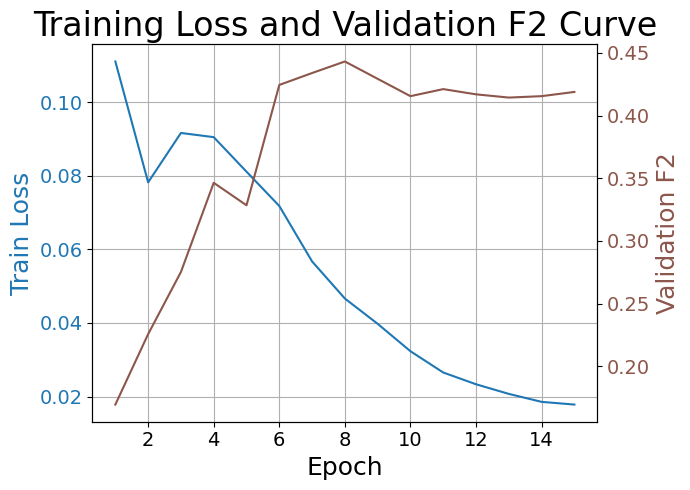

In [26]:
def plot_loss_and_f2(train_losses, val_f2s):
    # X-axis values: epoch numbers, starting at 1
    epochs = range(1, len(train_losses) + 1)

    # Create a new figure and primary axis (for loss)
    fig, ax1 = plt.subplots(figsize=(7, 5))

    # Plot training loss (primary y-axis, left)
    color = 'tab:blue'
    ax1.set_xlabel('Epoch', fontsize=18)  # X-axis label
    ax1.set_ylabel('Train Loss', color=color, fontsize=18)  # Y-axis label for loss
    ax1.plot(epochs, train_losses, color=color, label="Train Loss")  # Plot line
    ax1.tick_params(axis='y', labelcolor=color, labelsize=14)  # Tick color and size for y-axis (loss)
    ax1.tick_params(axis='x', labelsize=14)  # Tick size for x-axis (epochs)
    ax1.grid(True)  # Add gridlines for readability

    # Create a secondary y-axis for validation F2 score (on the right)
    ax2 = ax1.twinx()
    color = 'tab:brown'
    ax2.set_ylabel('Validation F2', color=color, fontsize=18)  # Y-axis label for F2
    ax2.plot(epochs, val_f2s, color=color, label="Validation F2")  # Plot validation F2
    ax2.tick_params(axis='y', labelcolor=color, labelsize=14)  # Tick color and size for y-axis (F2)

    # Add a title to the figure
    plt.title("Training Loss and Validation F2 Curve", fontsize=24)

    # Adjust layout to prevent label overlap/cutoff
    fig.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
plot_loss_and_f2(train_losses, val_f2s_all)


## Run Inference on the model and generate submission for kaggle competition (Code Provided by BYU Kaggle)

In [27]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Detection parameters
CONFIDENCE_THRESHOLD = 0.45  # Lower threshold to catch more potential motors
MAX_DETECTIONS_PER_TOMO = 3  # Keep track of top N detections per tomogram
NMS_IOU_THRESHOLD = 0.2  # Non-maximum suppression threshold for 3D clustering
CONCENTRATION = 1 # ONLY PROCESS 1/20 slices for fast submission

# GPU profiling context manager
class GPUProfiler:
    def __init__(self, name):
        self.name = name
        self.start_time = None

    def __enter__(self):
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.start_time = time.time()
        return self

    def __exit__(self, *args):
        if torch.cuda.is_available():
          elapsed = time.time() - self.start_time
          print(f"[PROFILE] {self.name}: {elapsed:.3f}s")

# Check GPU availability and set up optimizations
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 8  # Default batch size, will be adjusted dynamically if GPU available

if device.startswith('cuda'):
    # Set CUDA optimization flags
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
    torch.backends.cudnn.allow_tf32 = True

    # Print GPU info
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert to GB
    print(f"Using GPU: {gpu_name} with {gpu_mem:.2f} GB memory")

    # Get available GPU memory and set batch size accordingly
    free_mem = gpu_mem - torch.cuda.memory_allocated(0) / 1e9
    BATCH_SIZE = max(8, min(32, int(free_mem * 4)))  # 4 images per GB as rough estimate
    print(f"Dynamic batch size set to {BATCH_SIZE} based on {free_mem:.2f}GB free memory")
else:
    print("GPU not available, using CPU")
    BATCH_SIZE = 4  # Reduce batch size for CPU


def load_and_preprocess_image(img_path):
    # Loads image as PIL, converts to tensor, normalizes as expected by torchvision models
    img = Image.open(img_path).convert("RGB")
    preprocess = T.Compose([
        T.ToImage(),                                # Convert PIL image to torch.Tensor
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(img)


def preload_image_batch(file_paths):
    """Preload a batch of images to CPU memory"""
    images = []
    for path in file_paths:
        img = cv2.imread(path)
        if img is None:
            # Try with PIL as fallback
            img = np.array(Image.open(path))
        images.append(img)
    return images

def process_tomogram(tomo_id, model, index=0, total=1):
    print(f"Processing tomogram {tomo_id} ({index}/{total})")
    tomo_dir = os.path.join(TEST_DIR, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])

    selected_indices = np.linspace(0, len(slice_files)-1, int(len(slice_files) * CONCENTRATION))
    selected_indices = np.round(selected_indices).astype(int)
    slice_files = [slice_files[i] for i in selected_indices]

    print(f"Processing {len(slice_files)} out of {len(os.listdir(tomo_dir))} slices based on CONCENTRATION={CONCENTRATION}")

    all_detections = []

    for idx, slice_file in enumerate(slice_files):
        img_path = os.path.join(tomo_dir, slice_file)
        slice_num = int(slice_file.split('_')[1].split('.')[0])

        # Preprocess for Faster R-CNN
        image_tensor = load_and_preprocess_image(img_path).to(device).unsqueeze(0)  # shape (1, C, H, W)

        with torch.no_grad():
            outputs = model(image_tensor)

        boxes = outputs[0]['boxes'].cpu().numpy()  # (N, 4)
        scores = outputs[0]['scores'].cpu().numpy()  # (N,)
        labels = outputs[0]['labels'].cpu().numpy()  # (N,)

        # Filter out detections below confidence threshold and (optionally) by class
        for box, score, label in zip(boxes, scores, labels):
            if score >= CONFIDENCE_THRESHOLD:
                x1, y1, x2, y2 = box
                x_center = (x1 + x2) / 2
                y_center = (y1 + y2) / 2

                all_detections.append({
                    'z': round(slice_num),
                    'y': round(y_center),
                    'x': round(x_center),
                    'confidence': float(score)
                })

    # Non-maximum suppression as before
    final_detections = perform_3d_nms(all_detections, NMS_IOU_THRESHOLD)
    final_detections.sort(key=lambda x: x['confidence'], reverse=True)

    if not final_detections:
        return {
            'tomo_id': tomo_id,
            'Motor axis 0': -1,
            'Motor axis 1': -1,
            'Motor axis 2': -1
        }

    best_detection = final_detections[0]
    return {
        'tomo_id': tomo_id,
        'Motor axis 0': round(best_detection['z']),
        'Motor axis 1': round(best_detection['y']),
        'Motor axis 2': round(best_detection['x'])
    }


def perform_3d_nms(detections, iou_threshold):
    """
    Perform 3D Non-Maximum Suppression on detections to merge nearby motors
    """
    if not detections:
        return []

    # Sort by confidence (highest first)
    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)

    # List to store final detections after NMS
    final_detections = []

    # Define 3D distance function
    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 +
                       (d1['y'] - d2['y'])**2 +
                       (d1['x'] - d2['x'])**2)

    # Maximum distance threshold (based on box size and slice gap)
    box_size = 24  # Same as annotation box size
    distance_threshold = box_size * iou_threshold

    # Process each detection
    while detections:
        # Take the detection with highest confidence
        best_detection = detections.pop(0)
        final_detections.append(best_detection)

        # Filter out detections that are too close to the best detection
        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]

    return final_detections

def debug_image_loading(tomo_id):
    """
    Debug function to check image loading
    """
    tomo_dir = os.path.join(TEST_DIR, tomo_id)
    slice_files = sorted([f for f in os.listdir(tomo_dir) if f.endswith('.jpg')])

    if not slice_files:
        print(f"No image files found in {tomo_dir}")
        return

    print(f"Found {len(slice_files)} image files in {tomo_dir}")
    sample_file = slice_files[len(slice_files)//2]  # Middle slice
    img_path = os.path.join(tomo_dir, sample_file)

    # Try different loading methods
    try:
        # Method 1: PIL
        img_pil = Image.open(img_path)
        img_array_pil = np.array(img_pil)
        print(f"PIL Image shape: {img_array_pil.shape}, dtype: {img_array_pil.dtype}")

        # Method 2: OpenCV
        img_cv2 = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        print(f"OpenCV Image shape: {img_cv2.shape}, dtype: {img_cv2.dtype}")

        # Method 3: Convert to RGB
        img_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        print(f"OpenCV RGB Image shape: {img_rgb.shape}, dtype: {img_rgb.dtype}")

        print("Image loading successful!")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")


def generate_submission():
    """
    Main function to generate the submission file
    """
    # Get list of test tomograms
    test_tomos = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])
    total_tomos = len(test_tomos)

    print(f"Found {total_tomos} tomograms in test directory")

    # Debug image loading for the first tomogram
    if test_tomos:
        debug_image_loading(test_tomos[0])

    # Clear GPU cache before starting
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.to(device)
    model.eval()
    print(f"Loaded Faster R-CNN model onto {device}")

    # Process tomograms with parallelization
    results = []
    motors_found = 0

    # Using ThreadPoolExecutor with max_workers=1 since each worker uses the GPU already
    # and we're parallelizing within each tomogram processing
    with ThreadPoolExecutor(max_workers=1) as executor:
        future_to_tomo = {}

        # Submit all tomograms for processing
        for i, tomo_id in enumerate(test_tomos, 1):
            future = executor.submit(process_tomogram, tomo_id, model, i, total_tomos)
            future_to_tomo[future] = tomo_id

        # Process completed futures as they complete
        for future in future_to_tomo:
            tomo_id = future_to_tomo[future]
            try:
                # Clear CUDA cache between tomograms
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                result = future.result()
                results.append(result)

                # Update motors found count
                has_motor = not pd.isna(result['Motor axis 0'])
                if has_motor:
                    motors_found += 1
                    print(f"Motor found in {tomo_id} at position: "
                          f"z={result['Motor axis 0']}, y={result['Motor axis 1']}, x={result['Motor axis 2']}")
                else:
                    print(f"No motor detected in {tomo_id}")

                print(f"Current detection rate: {motors_found}/{len(results)} ({motors_found/len(results)*100:.1f}%)")

            except Exception as e:
                print(f"Error processing {tomo_id}: {e}")
                # Create a default entry for failed tomograms
                results.append({
                    'tomo_id': tomo_id,
                    'Motor axis 0': -1,
                    'Motor axis 1': -1,
                    'Motor axis 2': -1
                })

    # Create submission dataframe
    submission_df = pd.DataFrame(results)

    # Ensure proper column order
    submission_df = submission_df[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]

    # Save the submission file
    submission_df.to_csv(SUBMIT_PATH, index=False)

    print(f"\nSubmission complete!")
    print(f"Motors detected: {motors_found}/{total_tomos} ({motors_found/total_tomos*100:.1f}%)")
    print(f"Submission saved to: {SUBMIT_PATH}")

    # Display first few rows of submission
    print("\nSubmission preview:")
    print(submission_df.head())

    # Load ground truth labels
    ground_truth_df = pd.read_csv(LABELS_PATH)

    print("\nGround truth for tomograms in this submission:")
    for tomo_id in submission_df['tomo_id']:
        gt_row = ground_truth_df[ground_truth_df['tomo_id'] == tomo_id]
        if not gt_row.empty:
            gt_vals = gt_row.iloc[0]
            print(f"{tomo_id}: {gt_vals['Motor axis 0']}, {gt_vals['Motor axis 1']}, {gt_vals['Motor axis 2']}")
        else:
            print(f"{tomo_id}: No ground truth found")


    return submission_df

# Run the submission pipeline
if __name__ == "__main__":
    # Time entire process
    start_time = time.time()

    # Generate submission
    submission = generate_submission()

    # Print total execution time
    elapsed = time.time() - start_time
    print(f"\nTotal execution time: {elapsed:.2f} seconds ({elapsed/60:.2f} minutes)")

Using GPU: NVIDIA A100-SXM4-40GB with 42.47 GB memory
Dynamic batch size set to 32 based on 40.99GB free memory
Found 3 tomograms in test directory
Found 500 image files in /content/drive/MyDrive/Phys417FinalProject/BacterialFlagellarMotorsData/test/tomo_003acc
PIL Image shape: (1912, 1847), dtype: uint8
OpenCV Image shape: (1912, 1847), dtype: uint8
OpenCV RGB Image shape: (1912, 1847, 3), dtype: uint8
Image loading successful!
Loaded Faster R-CNN model onto cuda:0
Processing tomogram tomo_003acc (1/3)
Processing 500 out of 500 slices based on CONCENTRATION=1
Processing tomogram tomo_00e047 (2/3)
Motor found in tomo_003acc at position: z=-1, y=-1, x=-1
Current detection rate: 1/1 (100.0%)
Processing 300 out of 300 slices based on CONCENTRATION=1
Processing tomogram tomo_01a877 (3/3)Motor found in tomo_00e047 at position: z=169, y=545, x=603
Current detection rate: 2/2 (100.0%)

Processing 300 out of 300 slices based on CONCENTRATION=1
Motor found in tomo_01a877 at position: z=142, y=6